## Visualization utilities

In [3]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

## Download test image

Let's grab a test image that we'll use later. The image is from [Unsplash](https://unsplash.com/photos/mt2fyrdXxzk).

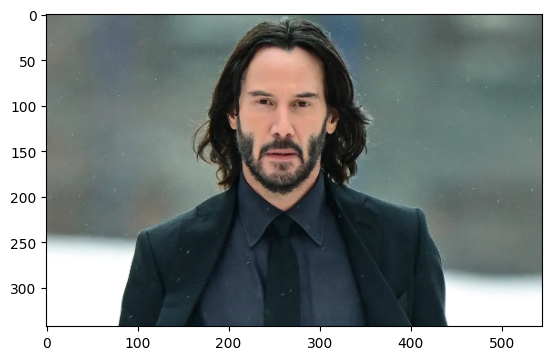

In [11]:
import cv2

img = cv2.imread("../data/keanu.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


Optionally, you can upload your own image. If you want to do so, uncomment and run the cell below.

In [12]:
# from google.colab import files
# uploaded = files.upload()

# for filename in uploaded:
#   content = uploaded[filename]
#   with open(filename, 'wb') as f:
#     f.write(content)

# if len(uploaded.keys()):
#   IMAGE_FILE = next(iter(uploaded))
#   print('Uploaded file:', IMAGE_FILE)

I0000 00:00:1699832005.799406   20092 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1699832005.866653   21156 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 470.199.02), renderer: NVIDIA GeForce GTX 1050/PCIe/SSE2
W0000 00:00:1699832005.867093   20092 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


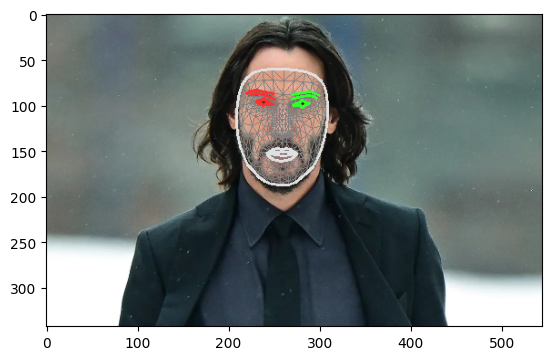

In [27]:
# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='./face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("../data/keanu.png")

# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.

annotated_image = draw_landmarks_on_image(cv2.imread("../data/keanu.png"), detection_result)

plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))

We will also visualize the face blendshapes categories using a bar graph.

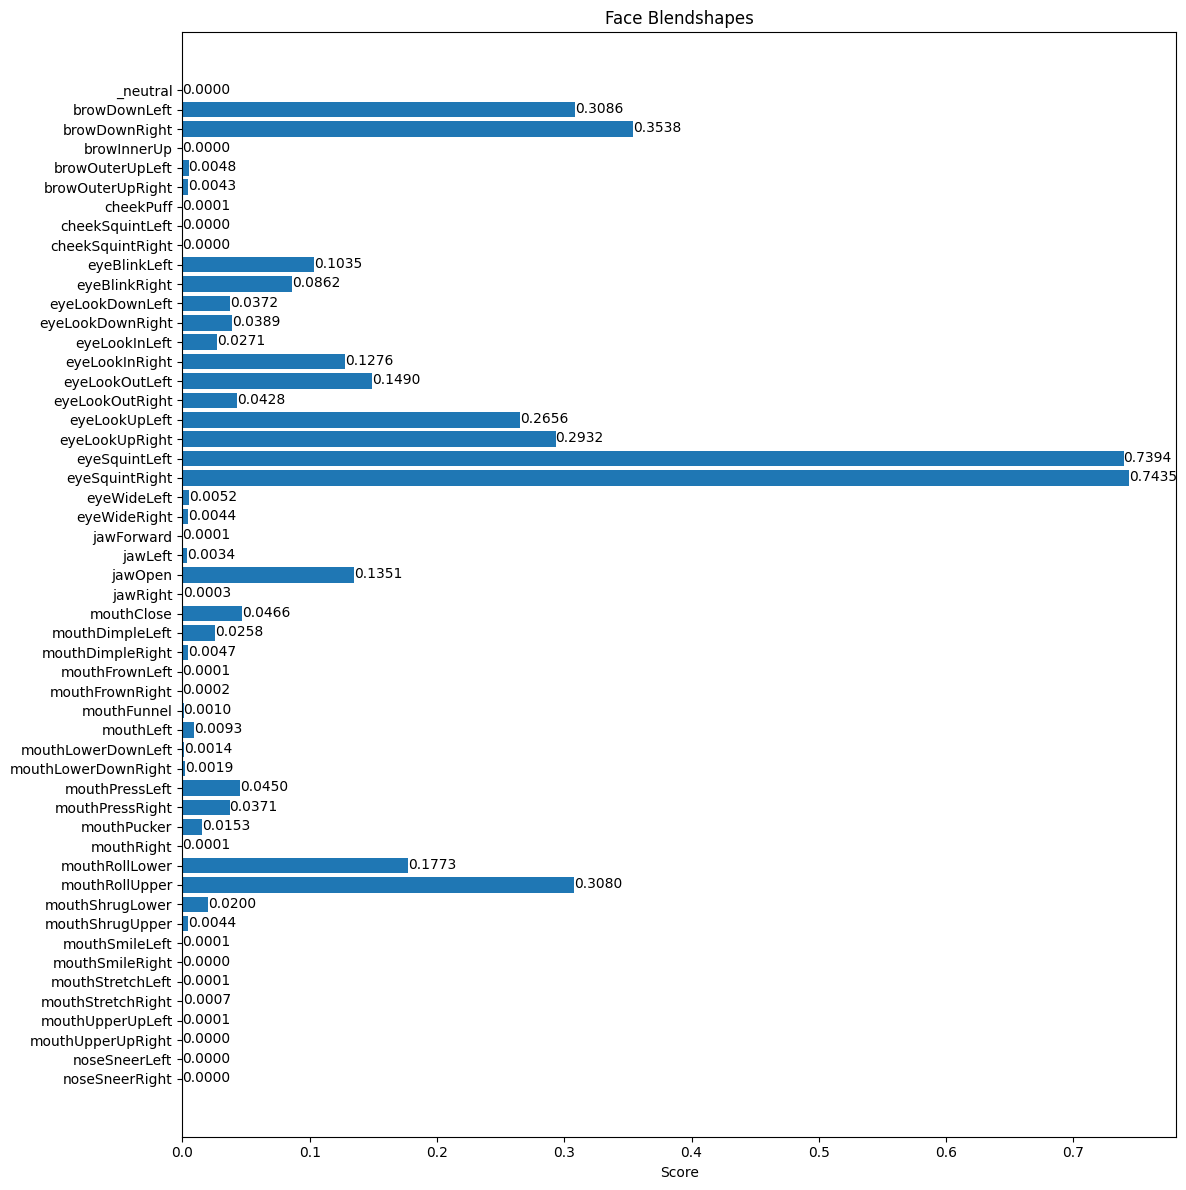

In [28]:
plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])

And print the transformation matrix.

In [29]:
print(detection_result.facial_transformation_matrixes)

[array([[ 9.99073803e-01,  4.15451527e-02,  1.11931209e-02,
        -1.88290513e+00],
       [-3.90003473e-02,  9.84282374e-01, -1.72239780e-01,
         7.85467339e+00],
       [-1.81729123e-02,  1.71643689e-01,  9.84991491e-01,
        -4.34351349e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])]


In [6]:
import cv2
def bgremove(frame, min_thres=50, min_satur=0, min_brigth=30):
    
    # Valores limite del color de la piel
    min_piel = np.array([min_thres, min_satur, min_brigth])
    max_piel = np.array([255, 255, 255])

    # Se aplica un blurr Gausioano para eliminar ruido y se convierte a HSV
    frameHSV = cv2.GaussianBlur(frame, (7, 7), 0)
    frameHSV = cv2.cvtColor(frameHSV, cv2.COLOR_RGB2HSV)

    # mascara que obtine el color del tono de piel del frame
    skinRegion = cv2.inRange(frameHSV, min_piel, max_piel)
    frame_skin = cv2.bitwise_and(frame, frame, mask=skinRegion)

    return frame_skin

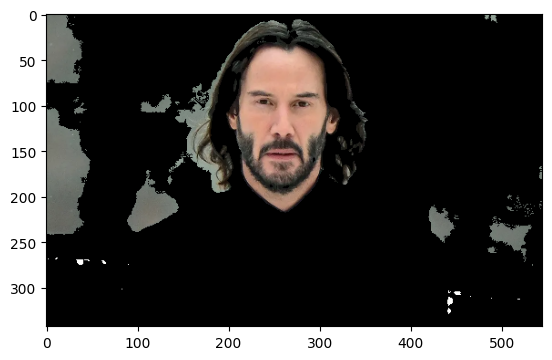

In [7]:
img = cv2.imread("../data/keanu.png")
plt.imshow(cv2.cvtColor(bgremove(img), cv2.COLOR_BGR2RGB))